## インポート

In [62]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import sklearn
from sklearn.cluster import KMeans
import random
from PIL import Image
import torch
import torchvision
from torchvision import datasets, models, transforms
import os

## クラス、変数定義

In [63]:
directory_path = "D:/Work/ImageRecognition/Images/%s"
food_path = "food_142/"
flower_path = "flower_142/"
food_test_path = "food_test/"
flower_test_path = "flower_test/"
num_classes = 2

class FoodFlowerDataset(torch.utils.data.Dataset):

    def __init__(self, transform=None, train=True):
        self.transform = transform
        self.images = []
        self.labels = []
        if train:
            food_folder = directory_path%(food_path)
            flower_folder = directory_path%(flower_path)
        else:
            food_folder = directory_path%(food_test_path)
            flower_folder = directory_path%(flower_test_path)
        self.images.extend([food_folder + p for p in os.listdir(food_folder)])
        self.labels.extend([0] * len(self.images))
        self.images.extend([flower_folder + p for p in os.listdir(flower_folder)])
        self.labels.extend([1] * (len(self.images)-len(self.labels)))
        self.randindex = list(range(len(self.images)))
        random.shuffle(self.randindex)
        
    def __getitem__(self, index):
        tmpindex = self.randindex[index]
        image = self.images[tmpindex]
        label = self.labels[tmpindex]
        with open(image, "rb") as f:
            image = Image.open(f)
            image = image.convert("RGB")
        if self.transform is not None:
            image = self.transform(image)
        return image, label
        
    def __len__(self):
        return len(self.images)

center_transforms = transforms.Compose([
        transforms.Resize(256), 
        transforms.CenterCrop(224),
    ])

train_dataset = FoodFlowerDataset(transform=center_transforms, train=True)
test_dataset = FoodFlowerDataset(transform=center_transforms, train=False)

train_image = []
train_label = []
test_image = []
test_label = []

for image, label in train_dataset:
    train_image.append(np.array(image))
    train_label.append(label)
    
for image, label in test_dataset:
    test_image.append(np.array(image))
    test_label.append(label)

    
train_image = np.array(train_image)
train_label = np.array(train_label)
test_image = np.array(test_image)
test_label = np.array(test_label)
    

0


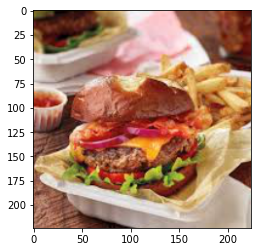

0


In [64]:
data_idx = random.randint(0, len(train_image))
print(data_idx)
plt.imshow(train_image[data_idx])
plt.show()
print(train_label[data_idx])

## 学習

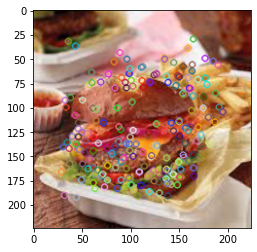

In [65]:
akaze_obj = cv2.AKAZE_create()

features_list = []
for idx, x_image in enumerate(train_image):
    # 画像をグレイスケールに変換する
    gray = cv2.cvtColor(x_image, cv2.COLOR_BGR2GRAY)
    
    # AKAZEで検出＋記述
    ## keypoints: キーポイントの位置・方向等の情報（分類では使わない）
    ## features：　キーポイント上の画像特徴量 (検出したKeyPointの数 x 128次元)
    keypoints, features = akaze_obj.detectAndCompute(gray, None)

    # SIFTの特徴量をリストに追加していく
    features_list.append(features)
    
    # どんなKey Pointを取り出したか確認してみる
    if idx is data_idx:
        kp_img = cv2.drawKeypoints(x_image, keypoints, None)
        plt.imshow(kp_img)

In [66]:
# 学習データの画像特徴量
flat_features_list = []
for features in features_list:
    flat_features_list.extend(features)
flat_features_list = np.array(flat_features_list)

# クラスタリングにはKMeansを使う
n_clusters = 16
kmeans_obj = KMeans(n_clusters=n_clusters, random_state=0)
kmeans_obj.fit(flat_features_list)

KMeans(n_clusters=16, random_state=0)

In [67]:
img_feature_list = []
for features in features_list:
    # 画像毎の処理
    # features: (検出したKeyPointの数 x 128次元)

    # 各KeyPointのfeatureがどのクラスタに所属するかを求める
    #   -> clustsers：　(検出したKeyPointの数 x 1) 
    #        値は所属するクラスタのIDが
    #        IDは、上の.fit()の段階で勝手に決められている
    clusters =  kmeans_obj.predict(features)

    # np.histogramで各クラスタの割当回数（=単語の出現回数)のデータに変換
    hist_data, _ = np.histogram(clusters, bins=n_clusters, range=(0, n_clusters))

    # データをリストに追加
    img_feature_list.append(hist_data)

# Numpy Arrayに変換しておく（この方が扱いやすい）
img_feature_list = np.array(img_feature_list)

In [68]:
svm_model = sklearn.svm.SVC()
svm_model.fit(img_feature_list, train_label)

pred_train = svm_model.predict(img_feature_list)
accuracy_train = sklearn.metrics.accuracy_score(train_label, pred_train)
print(accuracy_train)

0.855


## テスト

In [69]:
test_features_list = []
for x_image in test_image:
    # 画像をグレイスケールに変換する
    gray = cv2.cvtColor(x_image, cv2.COLOR_BGR2GRAY)
    
    # AKAZEで検出＋記述
    ## keypoints: キーポイントの位置・方向等の情報（分類では使わない）
    ## features：　キーポイント上の画像特徴量 (検出したKeyPointの数 x 128次元)
    keypoints, features = akaze_obj.detectAndCompute(gray, None)

    # AKAZEの特徴量をリストに追加していく
    test_features_list.append(features)

In [70]:
test_img_feature_list = []
for features in test_features_list:
    clusters =  kmeans_obj.predict(features)

    # np.histogramで各クラスタの割当回数（=単語の出現回数)のデータに変換
    hist_data, _ = np.histogram(clusters, bins=n_clusters, range=(0, n_clusters))

    # データをリストに追加
    test_img_feature_list.append(hist_data)

# Numpy Arrayに変換しておく（この方が扱いやすい）
test_img_feature_list = np.array(test_img_feature_list)

In [71]:
pred_test = svm_model.predict(test_img_feature_list)
accuracy_test = sklearn.metrics.accuracy_score(test_label, pred_test)
print(accuracy_test)

0.6764705882352942
